In [1]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from dev import utils, completeness, abc_occurrence
from tqdm.notebook import tqdm
from functools import partial
import warnings
from dev.constants import minmeanmax
# warnings.simplefilter('error', RuntimeWarning)

%load_ext autoreload
%autoreload 2

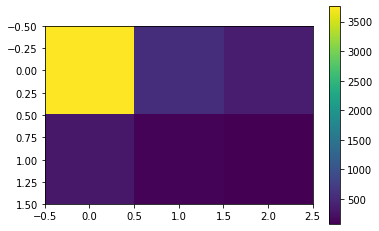

In [2]:
kois, stellar = utils.get_paired_kepler_catalogs()
period_bins = np.array([0.5, 100, 320])
rp_bins = np.array([0.5, 3, 6, 16])
log_p_bins, log_r_bins = np.log(period_bins), np.log(rp_bins)
log_p_bins = np.append(log_p_bins, float('inf'))
log_r_bins = np.append(log_r_bins, float('inf'))
period_rng = (min(period_bins), max(period_bins))
rp_rng = (min(rp_bins), max(rp_bins))

f = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)
lam = np.sum(f)
plt.imshow(np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0])
plt.colorbar()

Text(0.5, 1.0, 'pcomps')

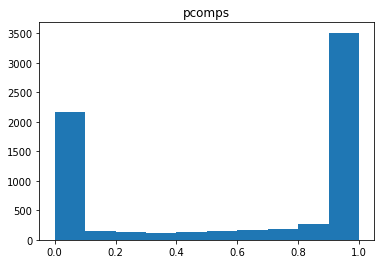

In [3]:
combined = pd.merge(kois, stellar, on='kepid')
cosincls = np.cos(np.pi * combined['koi_incl'].values / 180)
pcomp = completeness.get_pcomp(combined['koi_period'].values, combined['koi_prad'].values, 
                  combined['koi_eccen'].values, cosincls, combined)
plt.hist(pcomp[~np.isnan(pcomp)])
plt.title("pcomps")

3 detected planets


../dev/completeness.py:33: RuntimeWarning: invalid value encountered in sqrt
  multiple_event_stats = snr * np.sqrt(ntrn)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6817: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


Text(0.5, 1.0, 'Planet radii')

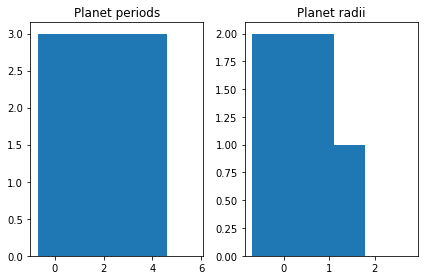

In [4]:
num_stars = 1000 or len(stellar)
stellar_sample = stellar.sample(n=num_stars)
want_to_save = False
st, pl = abc_occurrence.generate_planet_catalog(f, stellar_sample, log_p_bins, log_r_bins, add_noise=True)
if len(stellar_sample) == len(stellar) and want_to_save:
    pl.to_csv('../data/catalog_synth.csv')
print('{0} detected planets'.format(sum(pl.is_detected)))
detected_planets = pl[pl.is_detected]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(np.log(detected_planets.period), bins=log_p_bins)
axs[0].set_title("Planet periods")
axs[1].hist(np.log(detected_planets.prad), bins=log_r_bins)
axs[1].set_title("Planet radii")

Difference statistic: 0.00038295500337578184


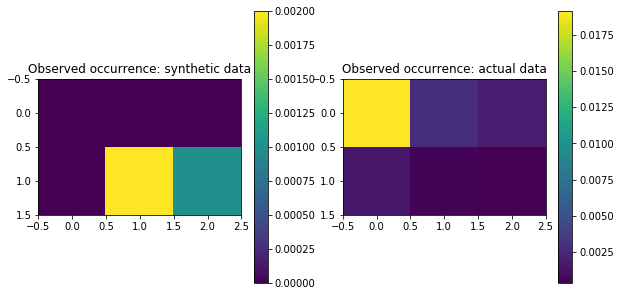

In [5]:
N = np.zeros_like(f)
detected = pl[pl.is_detected]
period_inds = np.digitize(np.log(detected.period), log_p_bins)
radius_inds = np.digitize(np.log(detected.prad), log_r_bins)
for i, j in zip(period_inds, radius_inds):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

sample_N = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
synth = axs[0].imshow(N)
axs[0].set_title("Observed occurrence: synthetic data")
fig.colorbar(synth, ax=axs[0])
actual = axs[1].imshow(sample_N)
axs[1].set_title("Observed occurrence: actual data")
fig.colorbar(actual, ax=axs[1])

print("Difference statistic: {0}".format(np.sum((N - sample_N) ** 2)))

In [6]:
stellar_sample = stellar.sample(n=100)
sampler = abc_occurrence.OccurrenceABCSampler(period_bins, rp_bins, stellar_sample)
kois_abc = abc_occurrence.kois_to_synth_catalog(period_bins, rp_bins, kois=kois, stellar=stellar)
abc_f = sampler.sample(kois_abc, threshold=0.06, verbose=True)

0.06401085582449581
0.06355605036865433


../dev/completeness.py:45: RuntimeWarning: overflow encountered in power
  pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
../dev/completeness.py:45: RuntimeWarning: invalid value encountered in subtract
  pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
../dev/completeness.py:46: RuntimeWarning: invalid value encountered in greater_equal
  msk = (pw >= 0.0) & (M >= 2.0)


0.06275984123014787
0.06404273983420175
0.06274721723684278
0.06405117602513082
0.06369038515892433


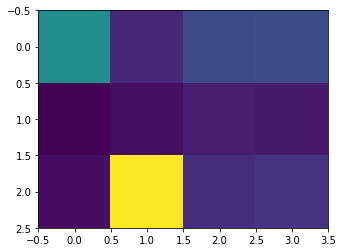

In [7]:
plt.imshow(abc_f.reshape((len(period_bins), len(rp_bins))))

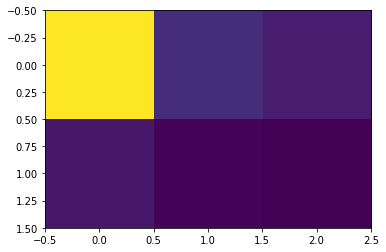

In [8]:
plt.imshow(f)

In [10]:
abc_pmc_f = sampler.sample_pmc(kois_abc, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 13)

12
0.06188763947461878
0.06392680182408869
0.05839520600344723
0.06294270286256323
0.06182026021291982
0.057372224221320586
0.06228648562414538
0.06389844065317288
0.06357427513186487
0.06383063052953794
0.06354942957566856
0.055180653889666094
0.06333009111213268
0.06322868787695664
0.05894231572924654
0.06327841375208028
0.05981510146164999
0.059274910639455086
0.06313661967697032
0.05765699114656848
0.059709989811556514
0.0628862117883176
0.06416500584358367
0.06302940474637883
0.060278165282980044
0.06311750051884767


KeyboardInterrupt: 